<a href="https://colab.research.google.com/github/Suhanii054/Data-Analyst-Chatbot/blob/main/Data_Analysis_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install LangChain packages and Gemini API
!pip install -q langchain langchain-google-genai langchain-experimental pandas matplotlib plotly


In [3]:
from google.colab import userdata
import os

# Store API key securely in Colab Secrets
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

print("API Key loaded from Colab Secrets!")


API Key loaded from Colab Secrets!


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.memory import ConversationBufferMemory
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


In [5]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

print(" Google Drive mounted successfully!")

Mounted at /content/drive
 Google Drive mounted successfully!


In [6]:
from google.colab import files
import io

# Upload CSV file
uploaded = files.upload()

# Load the first uploaded file into DataFrame
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(f"✅ Dataset loaded: {filename}")
print(f"📊 Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\n📋 First few rows:")
df.head()


Saving all_filings_normalized.csv to all_filings_normalized.csv
✅ Dataset loaded: all_filings_normalized.csv
📊 Shape: 345 rows, 19 columns

📋 First few rows:


,id,accessionNo,formType,cik,ticker,entityName,filedAt,filingUrl,publicOfferingPrice_perShare,publicOfferingPrice_perShareText,publicOfferingPrice_total,publicOfferingPrice_totalText,employees_total,employees_asOfDate,entity_type,entity_name,entity_location,entity_value,entity_extra
0,de048fe4198168d728b2b9a96a6ef5ff,0001193125-10-008960,S-1/A,1325879,AVEO,AVEO PHARMACEUTICALS INC,2010-01-20T18:32:54-05:00,https://www.sec.gov/Archives/edgar/data/132587...,NaN,NaN,NaN,NaN,134,2009-11-01,NaN,NaN,NaN,NaN,NaN
1,29a643ffc69e7648ad5bb11299d1e087,0001013762-10-000129,S-1/A,1140098,OCAT,"ADVANCED CELL TECHNOLOGY, INC.",2010-01-20T17:30:43-05:00,https://www.sec.gov/Archives/edgar/data/114009...,NaN,NaN,NaN,NaN,13,2009-09-30,NaN,NaN,NaN,NaN,NaN
2,1ef11f7d22d41eacd37337ca0665b266,0001193805-10-000187,S-1,885462,GURE,"GULF RESOURCES, INC.",2010-01-20T17:19:17-05:00,https://www.sec.gov/Archives/edgar/data/885462...,NaN,NaN,NaN,NaN,696,2009-12-31,NaN,NaN,NaN,NaN,NaN
3,0a5a7e8ab835a79bda720bbe9bf6faca,0001013762-10-000126,S-1/A,1046995,EMAN,EMAGIN CORP,2010-01-20T17:18:21-05:00,https://www.sec.gov/Archives/edgar/data/104699...,NaN,NaN,NaN,NaN,65,2010-01-05,NaN,NaN,NaN,NaN,NaN
4,c588c2ae73be05c1491d906384224bb2,0001144204-10-002771,S-1/A,1410098,CRMD,CorMedix Inc.,2010-01-20T17:08:21-05:00,https://www.sec.gov/Archives/edgar/data/141009...,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Initialize Gemini LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=0,  # 0 = more precise, 1 = more creative
    convert_system_message_to_human=True
)

print("✅ Gemini model initialized!")
print(f"📡 Model: gemini-2.5-pro")


✅ Gemini model initialized!
📡 Model: gemini-2.5-pro


In [8]:
# Create agent optimized for Gemini with better error handling
agent = create_pandas_dataframe_agent(
    llm=llm,
    df=df,
    verbose=True,
    allow_dangerous_code=True,
    agent_type="tool-calling",
    handle_parsing_errors=True,
    max_iterations=5,  # Reduce from 10 to save tokens
    return_intermediate_steps=False
)

print("✅ Gemini-compatible agent created!")


✅ Gemini-compatible agent created!


/usr/local/lib/python3.12/dist-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(


In [9]:
from langchain.memory import ConversationBufferMemory
from langchain.agents import AgentExecutor

# Create memory to remember conversation history
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="output"
)

# Create the AgentExecutor with the agent and memory
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent,
    tools=agent.tools, # Use the tools from the pandas agent
    verbose=True,
    memory=memory,
    # Removed handle_parsing_errors=True as it might be causing a conflict
)

print("✅ Conversation memory added and AgentExecutor created!")
print("🧠 Agent can now remember previous questions and context")

✅ Conversation memory added and AgentExecutor created!
🧠 Agent can now remember previous questions and context


/tmp/ipython-input-3109839088.py:5: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(


In [10]:
# Simple conversation history
conversation_history = []

def ask_with_context(question):
    """Ask question with conversation memory"""
    try:
        # Build context from history
        if conversation_history:
            context = "\n".join([f"Previous Q: {q}\nPrevious A: {a}"
                                for q, a in conversation_history[-2:]])
            full_question = f"{context}\n\nNew question: {question}"
        else:
            full_question = question

        # Get response
        response = agent.invoke(full_question)
        answer = response['output']

        # Save to history
        conversation_history.append((question, answer))

        return answer
    except Exception as e:
        return f"Error: {str(e)}"

print("✅ Memory function ready!")


✅ Memory function ready!


In [ ]:
# First question
print("💬 Question 1: What are the top 3 tickers by frequency?")
answer1 = ask_with_context("What are the top 3 tickers by frequency in this dataset?")
print(f"🤖 Answer: {answer1}\n")

# Follow-up question
print("💬 Question 2: How many filings does the first one have?")
answer2 = ask_with_context("How many filings does the first one have?")
print(f"🤖 Answer: {answer2}")


💬 Question 1: What are the top 3 tickers by frequency?


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "print(df['ticker'].value_counts().head(3))"}`


ticker
BWEN    8
AMCF    6
SYA     6
Name: count, dtype: int64
The top 3 tickers by frequency in this dataset are BWEN, AMCF, and SYA.

> Finished chain.
🤖 Answer: The top 3 tickers by frequency in this dataset are BWEN, AMCF, and SYA.

💬 Question 2: How many filings does the first one have?


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "print(df['ticker'].value_counts())"}`


ticker
BWEN      8
AMCF      6
SYA       6
CAVO      4
CELM      4
         ..
TNAV      2
FCFL      2
VG1       2
NCEN      2
ticker    1
Name: count, Length: 90, dtype: int64
The first ticker, BWEN, has 8 filings.

> Finished chain.
🤖 Answer: The first ticker, BWEN, has 8 filings.


In [11]:
def generate_auto_eda(dataframe):
    """
    Automatically generates comprehensive Exploratory Data Analysis
    This runs when user uploads a CSV
    """
    eda_report = {
        'basic_info': {},
        'statistics': {},
        'data_quality': {},
        'insights': []
    }

    # Basic Information
    eda_report['basic_info'] = {
        'total_rows': len(dataframe),
        'total_columns': len(dataframe.columns),
        'column_names': list(dataframe.columns),
        'data_types': dataframe.dtypes.to_dict(),
        'memory_usage': f"{dataframe.memory_usage(deep=True).sum() / 1024:.2f} KB"
    }

    # Data Quality Check
    eda_report['data_quality'] = {
        'missing_values': dataframe.isnull().sum().to_dict(),
        'missing_percentage': (dataframe.isnull().sum() / len(dataframe) * 100).to_dict(),
        'duplicate_rows': dataframe.duplicated().sum(),
        'unique_values_per_column': {col: dataframe[col].nunique() for col in dataframe.columns}
    }

    # Statistical Summary
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        eda_report['statistics']['numeric_summary'] = dataframe[numeric_cols].describe().to_dict()

    # Generate AI Insights
    print("🔍 Generating AI insights about your dataset...")

    return eda_report

# Run Auto-EDA on your dataset
eda_results = generate_auto_eda(df)
print("✅ Auto-EDA completed!")


🔍 Generating AI insights about your dataset...
✅ Auto-EDA completed!


In [ ]:
# Display EDA Results in readable format
print("=" * 60)
print("📊 AUTOMATED EXPLORATORY DATA ANALYSIS REPORT")
print("=" * 60)

print("\n📋 BASIC INFORMATION:")
print(f"  • Total Rows: {eda_results['basic_info']['total_rows']:,}")
print(f"  • Total Columns: {eda_results['basic_info']['total_columns']}")
print(f"  • Memory Usage: {eda_results['basic_info']['memory_usage']}")
print(f"  • Columns: {', '.join(eda_results['basic_info']['column_names'][:5])}...")

print("\n🔍 DATA QUALITY:")
print(f"  • Duplicate Rows: {eda_results['data_quality']['duplicate_rows']}")
missing_cols = {k: v for k, v in eda_results['data_quality']['missing_values'].items() if v > 0}
if missing_cols:
    print(f"  • Columns with Missing Values:")
    for col, count in list(missing_cols.items())[:5]:
        pct = eda_results['data_quality']['missing_percentage'][col]
        print(f"    - {col}: {count} ({pct:.1f}%)")
else:
    print(f"  • No Missing Values ✓")

print("\n📈 COLUMN INSIGHTS:")
for col in list(eda_results['data_quality']['unique_values_per_column'].keys())[:5]:
    unique_count = eda_results['data_quality']['unique_values_per_column'][col]
    print(f"  • {col}: {unique_count} unique values")

print("\n" + "=" * 60)


📊 AUTOMATED EXPLORATORY DATA ANALYSIS REPORT

📋 BASIC INFORMATION:
  • Total Rows: 345
  • Total Columns: 19
  • Memory Usage: 328.00 KB
  • Columns: id, accessionNo, formType, cik, ticker...

🔍 DATA QUALITY:
  • Duplicate Rows: 172
  • Columns with Missing Values:
    - ticker: 140 (40.6%)
    - publicOfferingPrice_perShare: 314 (91.0%)
    - publicOfferingPrice_perShareText: 314 (91.0%)
    - publicOfferingPrice_total: 314 (91.0%)
    - publicOfferingPrice_totalText: 314 (91.0%)

📈 COLUMN INSIGHTS:
  • id: 173 unique values
  • accessionNo: 148 unique values
  • formType: 4 unique values
  • cik: 157 unique values
  • ticker: 90 unique values



In [12]:
def auto_statistical_tests(dataframe):
    """
    Automatic statistical testing suite
    """
    from scipy import stats
    import numpy as np

    results = {}

    # 1. Normality tests for numeric columns
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
    results['normality_tests'] = {}

    for col in numeric_cols[:5]:  # Test first 5 columns
        stat, p_value = stats.normaltest(dataframe[col].dropna())
        results['normality_tests'][col] = {
            'is_normal': p_value > 0.05,
            'p_value': p_value
        }

    # 2. Correlation significance
    if len(numeric_cols) >= 2:
        corr_matrix = dataframe[numeric_cols].corr()
        results['high_correlations'] = []

        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr = corr_matrix.iloc[i, j]
                if abs(corr) > 0.7:  # Strong correlation
                    results['high_correlations'].append({
                        'col1': corr_matrix.columns[i],
                        'col2': corr_matrix.columns[j],
                        'correlation': corr
                    })

    # 3. Outlier detection using IQR
    results['outliers'] = {}
    for col in numeric_cols[:5]:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((dataframe[col] < (Q1 - 1.5 * IQR)) |
                   (dataframe[col] > (Q3 + 1.5 * IQR))).sum()
        results['outliers'][col] = outliers

    return results

print("✅ Statistical testing function created!")


✅ Statistical testing function created!


In [13]:
def display_statistical_results(results):
    """
    Display statistical test results in a readable format
    """
    print("=" * 60)
    print("📊 AUTOMATED STATISTICAL ANALYSIS")
    print("=" * 60)

    # 1. Normality Tests
    print("\n🔬 NORMALITY TESTS (p-value > 0.05 = Normal Distribution):")
    print("-" * 60)
    for col, test_result in results['normality_tests'].items():
        status = "✓ Normal" if test_result['is_normal'] else "✗ Not Normal"
        print(f"  • {col}: {status}")
        print(f"    p-value: {test_result['p_value']:.4f}")

    # 2. High Correlations
    print("\n🔗 HIGH CORRELATIONS (|r| > 0.7):")
    print("-" * 60)
    if results['high_correlations']:
        for corr_pair in results['high_correlations']:
            corr_val = corr_pair['correlation']
            strength = "Strong Positive" if corr_val > 0 else "Strong Negative"
            print(f"  • {corr_pair['col1']} ↔ {corr_pair['col2']}")
            print(f"    Correlation: {corr_val:.3f} ({strength})")
    else:
        print("  ✓ No strong correlations detected")

    # 3. Outliers
    print("\n⚠️ OUTLIER DETECTION (IQR Method):")
    print("-" * 60)
    for col, outlier_count in results['outliers'].items():
        if outlier_count > 0:
            print(f"  • {col}: {outlier_count} outliers detected")
        else:
            print(f"  • {col}: ✓ No outliers")

    print("\n" + "=" * 60)

print("✅ Display function created!")


✅ Display function created!


In [30]:
def query_data(question):
    """Helper function to query the agent"""
    try:
        result = agent.run(question)
        return result
    except Exception as e:
        return f"Unable to analyze: {str(e)}"

def get_ai_insights_parallel(dataframe, eda_report):
    """
    AI insights with PARALLEL execution using RunnableParallel
    Flow: prompt | model | parser (runs 3 times in parallel)
    """
    print(" AI is analyzing your data patterns IN PARALLEL...\n")

    # Create output parser
    parser = StrOutputParser()

    # Define 3 separate prompts for parallel execution
    summary_prompt = PromptTemplate.from_template(
        """Analyze this dataset with {total_rows} rows and {total_columns} columns.
        Columns: {column_names}
        Give a brief 2-sentence summary of what this dataset contains."""
    )

    quality_prompt = PromptTemplate.from_template(
        """This dataset has {duplicate_rows} duplicate rows and these missing values: {missing_info}.
        What data quality issues exist? List them briefly in 2-3 sentences."""
    )

    pattern_prompt = PromptTemplate.from_template(
        """Analyze this dataset with columns: {column_names} and {total_rows} rows.
        What are the 3 most interesting patterns or trends? Be specific and brief."""
    )

    # Create 3 parallel chains using LCEL pipe syntax
    # Each chain: prompt | model | parser
    summary_chain = summary_prompt | llm | parser
    quality_chain = quality_prompt | llm | parser
    pattern_chain = pattern_prompt | llm | parser

    # Combine into RunnableParallel - ALL RUN SIMULTANEOUSLY
    parallel_insights = RunnableParallel(
        summary=summary_chain,
        quality=quality_chain,
        patterns=pattern_chain
    )

    # Prepare input data for all chains
    input_data = {
        "total_rows": eda_report['basic_info']['total_rows'],
        "total_columns": eda_report['basic_info']['total_columns'],
        "column_names": ', '.join(eda_report['basic_info']['column_names']),
        "duplicate_rows": eda_report['data_quality']['duplicate_rows'],
        "missing_info": str({k: v for k, v in eda_report['data_quality']['missing_values'].items() if v > 0})
    }

    # Execute all 3 chains in parallel - THIS IS THE MAGIC
    results = parallel_insights.invoke(input_data)

    # Format results
    insights = [
        ("Dataset Overview", results['summary']),
        ("Data Quality Issues", results['quality']),
        ("Key Patterns", results['patterns'])
    ]

    return insights



In [15]:
# STEP 1: Generate the insights (this creates the ai_insights variable)
ai_insights = get_ai_insights_parallel(df, eda_results)

# STEP 2: Now display them (this uses the ai_insights variable)
print("\n" + "=" * 60)
print(" AI-POWERED INSIGHTS  (Parallel Execution)")
print("=" * 60)

for i, (title, insight) in enumerate(ai_insights, 1):
    print(f"\n{i}. {title}:")
    print(f"   {insight}")

print("\n" + "=" * 60)



🤖 AI is analyzing your data patterns IN PARALLEL...


🧠 AI-POWERED INSIGHTS ⚡ (Parallel Execution)

1. Dataset Overview:
   Based on the column names, this dataset contains structured information extracted from 345 corporate SEC filings, specifically focusing on public stock offerings. It provides key details for each filing, including company identifiers (ticker, CIK), the offering price per share and total value, filing dates, and general company information like employee count.

2. Data Quality Issues:
   This dataset has significant data quality issues, primarily redundancy and incompleteness. There are 172 duplicate rows which can skew analysis and create inconsistencies. Additionally, the data is highly incomplete, with crucial information missing across many columns, especially for all `entity` and `publicOfferingPrice` fields.

3. Key Patterns:
   Based on the column descriptions, here are the 3 most likely and interesting patterns in this dataset:

1.  **Skewed Offering Sizes 

In [31]:
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import numpy as np

def create_visualization(dataframe, viz_type, column=None, column2=None, top_n=10):
    """
    Enhanced visualization generator with multiple chart types
    viz_type: 'bar', 'hist', 'pie', 'line', 'scatter', 'box', 'heatmap'
    """
    plt.figure(figsize=(10, 6))

    if viz_type == 'bar' and column:
        # Bar chart for top values
        top_values = dataframe[column].value_counts().head(top_n)
        top_values.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'Top {top_n} {column} by Frequency', fontsize=14, fontweight='bold')
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

    elif viz_type == 'pie' and column:
        # Pie chart for distribution
        top_values = dataframe[column].value_counts().head(top_n)
        plt.pie(top_values, labels=top_values.index, autopct='%1.1f%%', startangle=90)
        plt.title(f'{column} Distribution (Top {top_n})', fontsize=14, fontweight='bold')

    elif viz_type == 'hist' and column:
        # Histogram for numeric data
        dataframe[column].dropna().hist(bins=30, color='coral', edgecolor='black')
        plt.title(f'Distribution of {column}', fontsize=14, fontweight='bold')
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)

    elif viz_type == 'line' and column:
        # Line chart for trends
        if dataframe[column].dtype in ['int64', 'float64']:
            dataframe[column].plot(kind='line', color='green', linewidth=2)
            plt.title(f'{column} Trend', fontsize=14, fontweight='bold')
            plt.xlabel('Index', fontsize=12)
            plt.ylabel(column, fontsize=12)
            plt.grid(True, alpha=0.3)

    elif viz_type == 'scatter' and column and column2:
        # Scatter plot for two numeric columns
        plt.scatter(dataframe[column], dataframe[column2], alpha=0.6, color='purple')
        plt.title(f'{column} vs {column2}', fontsize=14, fontweight='bold')
        plt.xlabel(column, fontsize=12)
        plt.ylabel(column2, fontsize=12)
        plt.grid(True, alpha=0.3)

    elif viz_type == 'box' and column:
        # Box plot for numeric data
        dataframe.boxplot(column=[column], vert=True, patch_artist=True)
        plt.title(f'{column} Box Plot', fontsize=14, fontweight='bold')
        plt.ylabel(column, fontsize=12)
        plt.grid(True, alpha=0.3)

    elif viz_type == 'heatmap':
        # Correlation heatmap for numeric columns
        numeric_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
        if len(numeric_cols) > 1:
            corr = dataframe[numeric_cols].corr()
            plt.imshow(corr, cmap='coolwarm', aspect='auto')
            plt.colorbar()
            plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
            plt.yticks(range(len(corr.columns)), corr.columns)
            plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
            plt.tight_layout()

    # Convert to base64
    buffer = BytesIO()
    plt.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.read()).decode()
    plt.close()

    return image_base64

print("✅ Enhanced visualization function with scatter, box, line, heatmap added!")


✅ Enhanced visualization function with scatter, box, line, heatmap added!


In [32]:
def auto_detect_visualization(question, dataframe):
    """
    Automatically detect if visualization is needed and what type
    Returns: (should_visualize, viz_type, column, column2)
    """
    question_lower = question.lower()

    # Keywords that trigger visualization
    viz_keywords = {
        'bar': ['top', 'most', 'frequent', 'common', 'highest', 'popular'],
        'pie': ['distribution', 'proportion', 'percentage', 'share'],
        'hist': ['histogram', 'distribution', 'spread', 'range'],
        'line': ['trend', 'over time', 'timeline', 'progression'],
        'scatter': ['relationship', 'correlation', 'vs', 'versus', 'compare'],
        'box': ['outliers', 'box plot', 'quartile', 'median'],
        'heatmap': ['correlation', 'correlate', 'related']
    }

    # Check if any visualization keyword is present
    detected_viz = None
    for viz_type, keywords in viz_keywords.items():
        if any(keyword in question_lower for keyword in keywords):
            detected_viz = viz_type
            break

    if not detected_viz:
        return False, None, None, None

    # Try to extract column names from question
    columns_found = []
    for col in dataframe.columns:
        if col.lower() in question_lower:
            columns_found.append(col)

    # Return visualization config
    if detected_viz == 'scatter' and len(columns_found) >= 2:
        return True, 'scatter', columns_found[0], columns_found[1]
    elif len(columns_found) >= 1:
        return True, detected_viz, columns_found[0], None
    else:
        # Use first categorical column as default
        cat_cols = dataframe.select_dtypes(include=['object']).columns
        if len(cat_cols) > 0:
            return True, detected_viz, cat_cols[0], None

    return False, None, None, None

print("✅ Smart auto-detection function created!")


✅ Smart auto-detection function created!


📊 Generating bar chart for top tickers...
✅ Bar chart created!


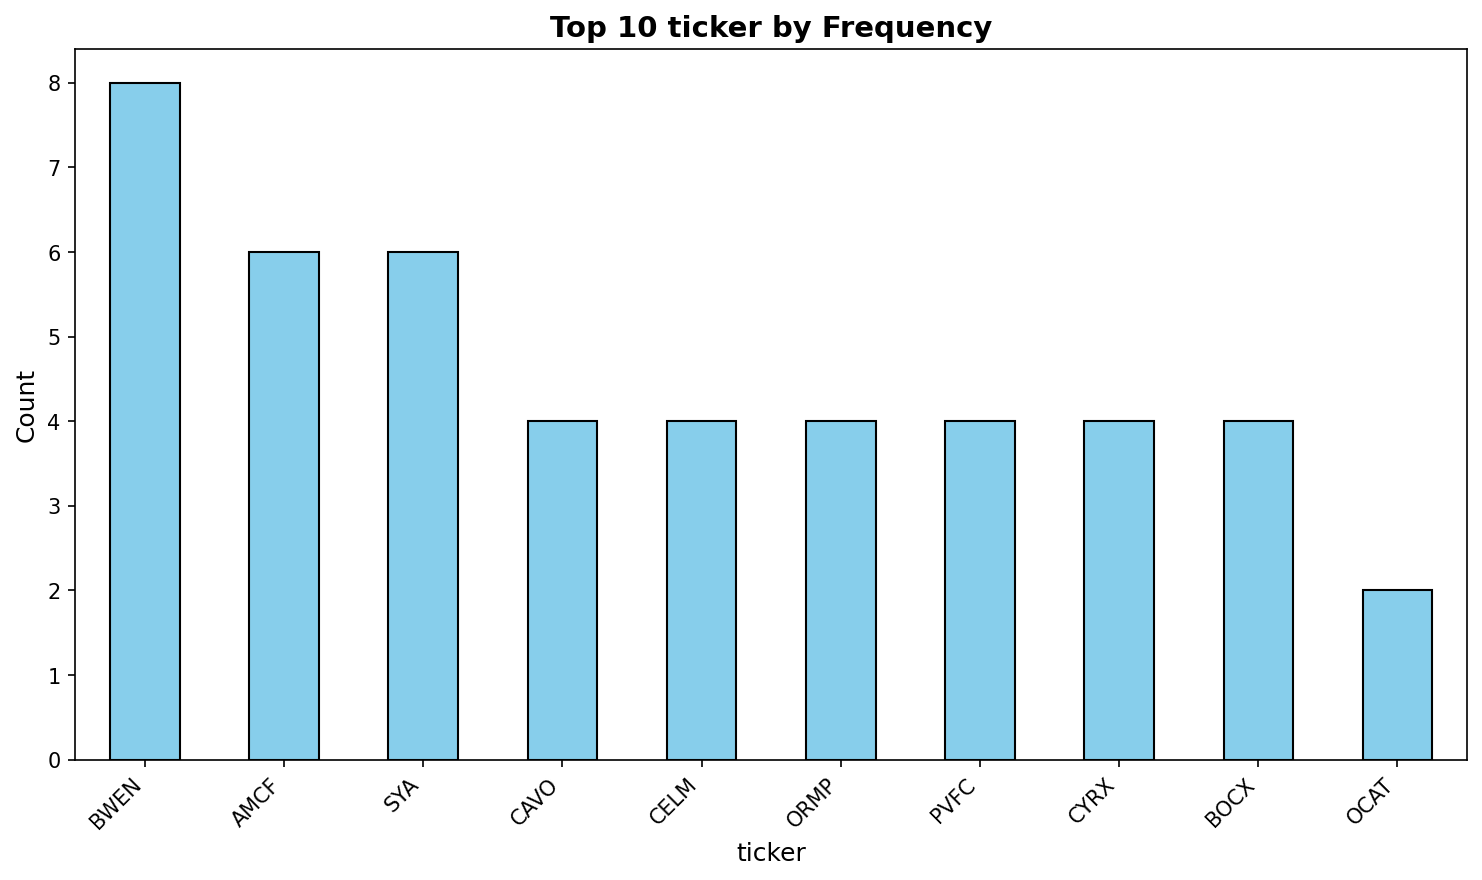


------------------------------------------------------------



In [ ]:
# Test 1: Bar chart of top tickers
print("📊 Generating bar chart for top tickers...")
viz1 = create_visualization(df, 'bar', column='ticker', top_n=10)
print("✅ Bar chart created!")

# Display the chart
from IPython.display import Image, display
display(Image(base64.b64decode(viz1)))

print("\n" + "-" * 60 + "\n")

# Test 2: Pie chart of filing items (if your dataset has that column)
# Adjust column name based on your actual data
if 'item' in df.columns:
    print("📊 Generating pie chart for filing items...")
    viz2 = create_visualization(df, 'pie', column='item', top_n=5)
    print("✅ Pie chart created!")
    display(Image(base64.b64decode(viz2)))


In [18]:
def parse_multi_query(question):
    """
    Detect and split multi-part questions
    Examples:
    - "Show me top 5 companies AND their filing counts AND any duplicates"
    - "What are the most common tickers, also show distribution, and check for missing values"
    """
    # Split indicators
    separators = [' and ', ' also ', ' plus ', ' additionally ', ', and ', '; ']

    # Check if multi-query
    question_lower = question.lower()
    is_multi = any(sep in question_lower for sep in separators)

    if not is_multi:
        return [question]  # Single query

    # Split into sub-queries
    sub_queries = [question]
    for sep in separators:
        temp = []
        for q in sub_queries:
            temp.extend(q.split(sep))
        sub_queries = temp

    # Clean and filter
    sub_queries = [q.strip() for q in sub_queries if q.strip()]

    return sub_queries

print("✅ Multi-query parser created!")


✅ Multi-query parser created!


In [19]:
from langchain_core.runnables import RunnableParallel, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

import time

def execute_multi_query_parallel(question):
    """
    Execute with automatic retry on rate limit errors
    """
    sub_queries = parse_multi_query(question)

    if len(sub_queries) == 1:
        return ask_with_context(question), False

    print(f"🔍 Detected {len(sub_queries)} sub-questions:\n")
    for i, sq in enumerate(sub_queries, 1):
        print(f"   {i}. {sq}")
    print()

    results = []
    for i, sub_q in enumerate(sub_queries, 1):
        max_retries = 3
        retry_count = 0

        while retry_count < max_retries:
            try:
                print(f"🤖 Answering part {i}/{len(sub_queries)}...")
                answer = agent.run(sub_q)
                results.append((sub_q, answer))
                print(f"✓ Part {i} completed\n")

                # Add delay between queries to avoid rate limits
                if i < len(sub_queries):
                    time.sleep(2)  # Wait 2 seconds between queries
                break

            except Exception as e:
                error_msg = str(e).lower()
                if 'rate limit' in error_msg or 'quota' in error_msg or '429' in error_msg:
                    retry_count += 1
                    wait_time = 5 * retry_count  # Exponential backoff
                    print(f"⚠️ Rate limit hit. Waiting {wait_time} seconds... (Retry {retry_count}/{max_retries})")
                    time.sleep(wait_time)
                else:
                    print(f"⚠️ Error in part {i}: {str(e)}")
                    results.append((sub_q, f"Error: {str(e)}"))
                    break

    # Combine results
    combined_answer = ""
    for i, (sq, ans) in enumerate(results, 1):
        combined_answer += f"**Part {i}: {sq}**\n{ans}\n\n"

    return combined_answer, True




In [20]:
class DataFilterAssistant:
    """
    Helps users create and manage filtered views of data
    """
    def __init__(self, original_dataframe):
        self.original_df = original_dataframe
        self.filtered_df = original_dataframe.copy()
        self.active_filters = []

    def apply_filter(self, filter_description):
        """
        Apply conversational filter
        Examples:
        - "only Intel filings"
        - "exclude rows with missing values"
        - "only filings from 2010"
        """
        try:
            # Use agent to generate filter code
            filter_prompt = f"""
            Given the dataframe with columns {list(self.filtered_df.columns)},
            create a pandas filter for: "{filter_description}"

            Return ONLY the filter condition code (like: df[df['ticker'] == 'INTC'])
            Do not include any explanation, just the code.
            """

            filter_code = agent.run(filter_prompt)

            # Extract actual filter condition
            # Simple execution - in production, sanitize this!
            self.filtered_df = eval(filter_code.replace('df', 'self.filtered_df'))
            self.active_filters.append(filter_description)

            return True, f"✓ Filter applied: {filter_description}\n  Rows remaining: {len(self.filtered_df)}"

        except Exception as e:
            return False, f"⚠️ Could not apply filter: {str(e)}"

    def reset_filters(self):
        """Remove all filters"""
        self.filtered_df = self.original_df.copy()
        self.active_filters = []
        return "✓ All filters removed. Back to original dataset."

    def get_status(self):
        """Show current filter status"""
        status = f"""
        📊 Filter Status:
        • Original rows: {len(self.original_df)}
        • Current rows: {len(self.filtered_df)}
        • Active filters: {len(self.active_filters)}
        """
        if self.active_filters:
            status += "\n  Filters applied:\n"
            for i, f in enumerate(self.active_filters, 1):
                status += f"    {i}. {f}\n"
        return status

# Initialize filter assistant
filter_assistant = DataFilterAssistant(df)

print("✅ Data Filtering Assistant created!")


✅ Data Filtering Assistant created!


In [ ]:
# Test 1: Multi-Query
print("TEST 1: Multi-Query Mode")
print("="*60)
test_q = "What are the top 3 tickers and also show me how many unique items exist"
result, is_multi = execute_multi_query_parallel(test_q)
print(f"\n📝 Combined Result:\n{result}")

print("\n" + "="*60 + "\n")

# Test 2: Filtering
print("TEST 2: Data Filtering")
print("="*60)
print(filter_assistant.get_status())

# Apply filter
success, msg = filter_assistant.apply_filter("only INTC ticker")
print(f"\n{msg}")
print(filter_assistant.get_status())

print("\n✅ Both features working! Ready to integrate into chat.")


TEST 1: Multi-Query Mode
🔍 Detected 2 sub-questions:

   1. What are the top 3 tickers
   2. also show me how many unique items exist

🤖 Answering part 1/2...


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df['ticker'].value_counts().nlargest(3)"}`


ticker
BWEN    8
AMCF    6
SYA     6
Name: count, dtype: int64
Invoking: `python_repl_ast` with `{'query': "df['ticker'].value_counts().nlargest(3)"}`


ticker
BWEN    8
AMCF    6
SYA     6
Name: count, dtype: int64The top 3 tickers are BWEN, AMCF, and SYA.

> Finished chain.
✓ Part 1 completed

🤖 Answering part 2/2...


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': 'df.nunique()'}`


id                                  173
accessionNo                         148
formType                              4
cik                                 157
ticker                               90
entityName                          157
filedAt                             148
filin

* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 2
Please retry in 25.915918422s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 2
}
, retry_delay {
  seconds: 25
}
].


Here are the number of unique items in each column of the dataframe:
id                                  173
accessionNo                         148
formType                              4
cik                                 157
ticker                               90
entityName                          157
filedAt                             148
filingUrl                           148
publicOfferingPrice_perShare         16
publicOfferingPrice_perShareText     16
publicOfferingPrice_total            16
publicOfferingPrice_totalText        16
employees_total                      74
employees_asOfDate                   25
entity_type                           1
entity_name                           1
entity_location                       1
entity_value                          1
entity_extra                          1
dtype: int64

> Finished chain.
✓ Part 2 completed


📝 Combined Result:
**Part 1: What are the top 3 tickers**
The top 3 tickers are BWEN, AMCF, and SYA.

**Part 2: also s

* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 2
Please retry in 23.832112086s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 2
}
, retry_delay {
  seconds: 23
}
].
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 2
Please retry in 19.762021008s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "G


Invoking: `python_repl_ast` with `{'query': "df[df['ticker'] == 'INTC']"}`


Empty DataFrame
Columns: [id, accessionNo, formType, cik, ticker, entityName, filedAt, filingUrl, publicOfferingPrice_perShare, publicOfferingPrice_perShareText, publicOfferingPrice_total, publicOfferingPrice_totalText, employees_total, employees_asOfDate, entity_type, entity_name, entity_location, entity_value, entity_extra]
Index: []df[df['ticker'] == 'INTC']

> Finished chain.

✓ Filter applied: only INTC ticker
  Rows remaining: 0

        📊 Filter Status:
        • Original rows: 345
        • Current rows: 0
        • Active filters: 1
        
  Filters applied:
    1. only INTC ticker


✅ Both features working! Ready to integrate into chat.


In [21]:
class DataAnalystChatbot:
    """
    Main chatbot class that handles conversations, queries, and visualizations
    """
    def __init__(self, dataframe, agent):
        self.df = dataframe
        self.agent = agent
        self.conversation_history = []
        self.eda_report = None

    def analyze_dataset(self):
        """Run initial EDA when dataset is loaded"""
        print("🔄 Running initial analysis on your dataset...\n")
        self.eda_report = generate_auto_eda(self.df)
        insights = get_ai_insights_parallel(self.df, self.eda_report)

        # Create welcome message
        welcome = f"""
        ✅ Dataset loaded successfully!

        📊 Quick Summary:
        • Rows: {self.eda_report['basic_info']['total_rows']:,}
        • Columns: {self.eda_report['basic_info']['total_columns']}
        • Memory: {self.eda_report['basic_info']['memory_usage']}

        💡 What would you like to know about your data?
        """
        return welcome, insights

    def ask(self, question):
        """Main chatbot query function"""
        try:
            # Check if question asks for visualization
            viz_keywords = ['plot', 'chart', 'graph', 'visualize', 'show me']
            needs_viz = any(keyword in question.lower() for keyword in viz_keywords)

            # Get answer from agent
            answer = self.agent.run(question)

            # Store in conversation history
            self.conversation_history.append({
                'question': question,
                'answer': answer,
                'needs_visualization': needs_viz
            })

            return answer, needs_viz

        except Exception as e:
            return f"⚠️ Error: {str(e)}", False

    def suggest_questions(self):
        """Suggest relevant questions based on dataset"""
        columns = list(self.df.columns)
        suggestions = [
            f"What are the top 10 values in {columns[0]}?",
            f"How many unique {columns[1] if len(columns) > 1 else columns[0]} are there?",
            "Show me summary statistics of this dataset",
            f"What is the distribution of {columns[0]}?",
            "Are there any missing values?",
            "Run statistical tests"  # ← NEW LINE
        ]
        return suggestions



print("✅ DataAnalystChatbot class created!")


✅ DataAnalystChatbot class created!


In [22]:
# Create chatbot (already using parallel for insights)
chatbot = DataAnalystChatbot(df, agent)

# Run initial analysis - THIS USES PARALLEL EXECUTION
welcome_msg, initial_insights = chatbot.analyze_dataset()
print(welcome_msg)

print("\n🧠 AI Insights:")
for i, (title, insight) in enumerate(initial_insights, 1):
    print(f"\n{i}. {title}:")
    print(f"   {insight}")

# Ask single question - uses normal execution
answer, needs_viz = chatbot.ask("What are the top 5 tickers?")
print(f"\n🤖 Answer: {answer}")



🔄 Running initial analysis on your dataset...

🔍 Generating AI insights about your dataset...
🤖 AI is analyzing your data patterns IN PARALLEL...



/tmp/ipython-input-3790497019.py:38: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  answer = self.agent.run(question)
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 2
Please retry in 14.404971052s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 2
}
, retry_delay {
  seconds: 14
}
].



        ✅ Dataset loaded successfully!

        📊 Quick Summary:
        • Rows: 345
        • Columns: 19
        • Memory: 328.00 KB

        💡 What would you like to know about your data?
        

🧠 AI Insights:

1. Dataset Overview:
   Based on the column names, this dataset contains structured information extracted from 345 corporate filings with the U.S. Securities and Exchange Commission (SEC). The data primarily focuses on the financial details of public offerings, including the price per share and total offering value, alongside general company information like employee counts, ticker symbols, and filing dates.

2. Data Quality Issues:
   This dataset has significant data quality issues, primarily redundancy and incompleteness. There are 172 duplicate rows which can skew analysis and create inconsistencies. Additionally, the data is highly incomplete, with crucial information missing across many columns, especially for all `entity` and `publicOfferingPrice` fields.

3. Key P

* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 2
Please retry in 12.313605646s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-pro"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 2
}
, retry_delay {
  seconds: 12
}
].
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 2
Please retry in 8.224470492s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "Ge


Invoking: `python_repl_ast` with `{'query': "print(df['ticker'].value_counts().head(5))"}`


ticker
BWEN    8
AMCF    6
SYA     6
CAVO    4
CELM    4
Name: count, dtype: int64
The top 5 tickers are:
- BWEN: 8
- AMCF: 6
- SYA: 6
- CAVO: 4
- CELM: 4

> Finished chain.

🤖 Answer: The top 5 tickers are:
- BWEN: 8
- AMCF: 6
- SYA: 6
- CAVO: 4
- CELM: 4


In [24]:
from IPython.display import Image, display

def start_chat_session():
    """
    Complete chat session with initial EDA analysis + interactive Q&A with auto-visualization + multi-query + filtering
    """

    # Step 1: Display EDA Report
    print("=" * 60)
    print("📊 AUTOMATED EXPLORATORY DATA ANALYSIS REPORT")
    print("=" * 60)

    print("\n📋 BASIC INFORMATION:")
    print(f"  • Total Rows: {eda_results['basic_info']['total_rows']:,}")
    print(f"  • Total Columns: {eda_results['basic_info']['total_columns']}")
    print(f"  • Memory Usage: {eda_results['basic_info']['memory_usage']}")
    print(f"  • Columns: {', '.join(eda_results['basic_info']['column_names'][:5])}...")

    print("\n🔍 DATA QUALITY:")
    print(f"  • Duplicate Rows: {eda_results['data_quality']['duplicate_rows']}")
    missing_cols = {k: v for k, v in eda_results['data_quality']['missing_values'].items() if v > 0}
    if missing_cols:
        print(f"  • Columns with Missing Values:")
        for col, count in list(missing_cols.items())[:5]:
            pct = eda_results['data_quality']['missing_percentage'][col]
            print(f"    - {col}: {count} ({pct:.1f}%)")
    else:
        print(f"  • No Missing Values ✓")

    print("\n📈 COLUMN INSIGHTS:")
    for col in list(eda_results['data_quality']['unique_values_per_column'].keys())[:5]:
        unique_count = eda_results['data_quality']['unique_values_per_column'][col]
        print(f"  • {col}: {unique_count} unique values")

    print("\n" + "=" * 60)

    # Step 2: Display AI Insights
    print("\n🤖 Generating AI-Powered Insights...\n")
    ai_insights = get_ai_insights_parallel(df, eda_results)

    print("=" * 60)
    print("🧠 AI-POWERED INSIGHTS")
    print("=" * 60)

    for i, (title, insight) in enumerate(ai_insights, 1):
        print(f"\n{i}. {title}:")
        print(f"   {insight}")

    print("\n" + "=" * 60)

    # Step 3: Start Interactive Chat
    print("\n" + "=" * 60)
    print("💬 INTERACTIVE CHAT - ASK ME ANYTHING!")
    print("=" * 60)
    print("💡 TIP: You can ask multiple questions using 'and' or 'also'")
    print("💡 TIP: Type 'filter: <condition>' to filter data (e.g., 'filter: only INTC')")
    print("💡 TIP: Type 'reset filters' to remove all filters")
    print("💡 TIP: Type 'filter status' to see active filters\n")
    print("💡 TIP: Type 'stat tests' to run automated statistical analysis\n")
    print("Type your questions below. Type 'exit' to stop.\n")

    while True:
        # Get user question
        question = input("\nYou: ")

        # Exit condition
        if question.lower() in ['exit', 'quit', 'bye']:
            print("\n👋 Chatbot: Goodbye! Happy analyzing!")
            break

        # Skip empty questions
        if not question.strip():
            continue

        # Check for filter commands
        if question.lower().startswith('filter:'):
            filter_desc = question[7:].strip()
            success, msg = filter_assistant.apply_filter(filter_desc)
            print(f"\n{msg}\n")
            print("-" * 60)
            continue

        if question.lower() == 'reset filters':
            msg = filter_assistant.reset_filters()
            print(f"\n{msg}\n")
            print("-" * 60)
            continue

        if question.lower() == 'filter status':
            print(f"\n{filter_assistant.get_status()}\n")
            print("-" * 60)
            continue

                  # NEW: Statistical tests command
        if question.lower() in ['stat tests', 'statistical tests', 'stats', 'run tests']:
            print("\n🔬 Running statistical analysis...\n")
            current_df = filter_assistant.filtered_df if len(filter_assistant.active_filters) > 0 else df
            stat_results = auto_statistical_tests(current_df)
            display_statistical_results(stat_results)

            # Optional: Ask AI for interpretation
            print("\n🤖 AI Interpretation:")
            interpretation_prompt = f"""
            Based on these statistical test results:
            - Normality tests: {stat_results['normality_tests']}
            - High correlations: {stat_results['high_correlations']}
            - Outliers detected: {stat_results['outliers']}

            Provide 3-4 key insights and recommendations in simple language.
            """
            ai_interpretation = llm.invoke(interpretation_prompt)
            print(ai_interpretation.content)
            print("-" * 60)
            continue


        # Execute query (handles both single and multi-query)
        print("\n🤖 Analyzing...\n")
        answer, is_multi = execute_multi_query_parallel(question)
        print(f"Chatbot: {answer}\n")

        # AUTOMATIC VISUALIZATION DETECTION (use filtered data if active)
        current_df = filter_assistant.filtered_df if len(filter_assistant.active_filters) > 0 else df
        should_viz, viz_type, col1, col2 = auto_detect_visualization(question, current_df)

        if should_viz and viz_type and col1:
            print(f"📊 Auto-generating {viz_type} chart for '{col1}'...\n")
            try:
                viz = create_visualization(current_df, viz_type, column=col1, column2=col2, top_n=10)
                display(Image(base64.b64decode(viz)))
            except Exception as e:
                print(f"⚠️ Could not generate visualization: {str(e)}")

        print("-" * 60)

print("✅ Complete chat session with all features ready!")


✅ Complete chat session with all features ready!


In [25]:
conversation_history = []

start_chat_session()


📊 AUTOMATED EXPLORATORY DATA ANALYSIS REPORT

📋 BASIC INFORMATION:
  • Total Rows: 345
  • Total Columns: 19
  • Memory Usage: 328.00 KB
  • Columns: id, accessionNo, formType, cik, ticker...

🔍 DATA QUALITY:
  • Duplicate Rows: 172
  • Columns with Missing Values:
    - ticker: 140 (40.6%)
    - publicOfferingPrice_perShare: 314 (91.0%)
    - publicOfferingPrice_perShareText: 314 (91.0%)
    - publicOfferingPrice_total: 314 (91.0%)
    - publicOfferingPrice_totalText: 314 (91.0%)

📈 COLUMN INSIGHTS:
  • id: 173 unique values
  • accessionNo: 148 unique values
  • formType: 4 unique values
  • cik: 157 unique values
  • ticker: 90 unique values


🤖 Generating AI-Powered Insights...

🤖 AI is analyzing your data patterns IN PARALLEL...

🧠 AI-POWERED INSIGHTS

1. Dataset Overview:
   Based on the column names, this dataset contains information extracted from 345 corporate SEC filings, with a specific focus on public stock offerings. For each filing, it captures company identifiers (like t

In [33]:
# Install Gradio
!pip install gradio -q

import gradio as gr

# ============================================
# Gradio UI - Calls your existing functions
# ============================================

def analyze_csv(csv_file, api_key):
    """Upload CSV and get analysis"""

    if not api_key:
        return "❌ Please enter your Google API Key"

    if csv_file is None:
        return "❌ Please upload a CSV file"

    try:
        # Set API key
        os.environ["GOOGLE_API_KEY"] = api_key

        # Load data
        global df, agent, llm
        df = pd.read_csv(csv_file)

        # Initialize LLM (your existing code)
        llm = ChatGoogleGenerativeAI(
            model="gemini-2.5-pro",
            temperature=0,
            convert_system_message_to_human=True
        )

        # Create agent (your existing code)
        agent = create_pandas_dataframe_agent(
            llm=llm,
            df=df,
            verbose=False,
            allow_dangerous_code=True,
            agent_type="tool-calling",
            handle_parsing_errors=True,
            max_iterations=10
        )

        # Run EDA (your existing function)
        eda_results = generate_auto_eda(df)

        # Generate AI insights (your existing function)
        ai_insights = get_ai_insights_parallel(df, eda_results)

        # Format output
        output = f"""
 ANALYSIS COMPLETE

📊 Dataset Info:
• Rows: {len(df):,}
• Columns: {len(df.columns)}
• Memory: {df.memory_usage(deep=True).sum() / 1024:.2f} KB

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
AI-POWERED INSIGHTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

        for i, (title, insight) in enumerate(ai_insights, 1):
            output += f"\n{i}. {title}:\n{insight}\n"

        return output

    except Exception as e:
        return f"❌ Error: {str(e)}"

def chat_function(question, chat_history):
    """Chat with your data"""
    try:
        if 'agent' not in globals() or agent is None:
            return chat_history + [[question, "❌ Please upload and analyze a CSV file first"]]

        # Call your existing agent
        response = agent.run(question)

        # Add to chat history
        chat_history.append([question, response])

        return chat_history

    except Exception as e:
        chat_history.append([question, f"❌ Error: {str(e)}"])
        return chat_history

# ============================================
# Create Gradio Interface
# ============================================

with gr.Blocks(title="AI Data Analyst ", theme=gr.themes.Soft()) as demo:

    # Header
    gr.Markdown("""
    # 🤖 AI Data Analyst
    ### Powered by Google Gemini + LangChain
    #### Upload CSV → Get AI Insights → Chat with Your Data
    """)

    with gr.Tab("📊 Analysis"):
        gr.Markdown("### Step 1: Enter API Key & Upload CSV")

        with gr.Row():
            api_key_input = gr.Textbox(
                label="🔑 Google API Key",
                type="password",
                placeholder="Paste your Gemini API key here"
            )

        with gr.Row():
            csv_file_input = gr.File(
                label="📁 Upload CSV File",
                file_types=[".csv"]
            )

        analyze_button = gr.Button(" Analyze Dataset", variant="primary", size="lg")

        analysis_output = gr.Textbox(
            label="📈 Analysis Results",
            lines=20,
            max_lines=30,
            interactive=False
        )

        analyze_button.click(
            fn=analyze_csv,
            inputs=[csv_file_input, api_key_input],
            outputs=analysis_output
        )

    with gr.Tab("💬 Chat"):
        gr.Markdown("### Ask Questions About Your Data")

        chatbot_display = gr.Chatbot(
            label="Conversation",
            height=400
        )

        with gr.Row():
            question_input = gr.Textbox(
                label="Your Question",
                placeholder="What are the top 5 values? Show me statistics...",
                scale=4
            )
            send_button = gr.Button("Send", variant="primary", scale=1)

        # Suggested questions
        gr.Markdown("### 💡 Try These Questions:")
        with gr.Row():
            gr.Examples(
                examples=[
                    ["What are the top 10 most frequent values?"],
                    ["Show me summary statistics"],
                    ["Are there any missing values?"],
                    ["What patterns do you see in this data?"],
                    ["What columns have the most variation?"]
                ],
                inputs=question_input
            )

        send_button.click(
            fn=chat_function,
            inputs=[question_input, chatbot_display],
            outputs=chatbot_display
        )

        question_input.submit(
            fn=chat_function,
            inputs=[question_input, chatbot_display],
            outputs=chatbot_display
        )

# ============================================
# Launch the App
# ============================================

print("\n" + "="*70)
print("🚀 LAUNCHING AI DATA ANALYST UI...")
print("="*70 + "\n")

demo.launch(share=True, debug=False)


/tmp/ipython-input-2579723547.py:138: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot_display = gr.Chatbot(



🚀 LAUNCHING AI DATA ANALYST UI...

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8a426c9f3f650c0393.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
